# Rede Neural Convolucional - Classificação Multiclasse

In [46]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import models, layers, datasets, utils, preprocessing

%matplotlib inline

## Obter os dados

In [47]:
# A base de dados já está dividida em dois conjuntos: treino e teste
(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()

In [48]:
# 60000 imagens para treino
len(X_train)

60000

In [49]:
# 10000 imagens para teste
len(X_test)

10000

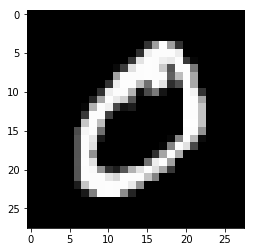

In [50]:
# Número zero a preto e branco
plt.imshow(X_train[1], cmap="gray")

In [51]:
# Matriz com os pixeis da imagem com o número zero
# Matriz 28x28
pixeis = X_train[1]
pixeis.shape

(28, 28)

# Pré-Processamento dos dados

In [52]:
# 60000 imagens para treino
X_train.shape[0]

60000

### Transformar os dados num vector em que o tensorflow consiga fazer a sua leitura.

In [53]:
# 1º parametro: número de imagens
# 2º parametro: Altura da imagem (nº de pixeis da imagem na vertical).
# 3º parametro: Largura da imagem (nº de pixeis da imagem na horizontal).

# Nº de canais de RGB: Como a cor não tem influência neste caso pode-se utilizar a imagem a preto e branco(rgb=1). Quando se 
# utilizam as imagens a cores (rgb=3) o algoritmo fica mais lento porque aumenta a dimensionalidade dos dados. Uma imagem a 
# cores tem 3 canais(valores) dentro de cada pixel, porque o pixel é subdividio em vermelho(r), verde(g e azul(b)). Com rgb=1 
# tem-se menos dados para processar.

# A escala de cinzento possui apenas um canal. Quanto mais próximo de 255 mais claro é o cinzento e quanto mais próximo de 
# 0 mais escura é a cor.
# Nesta escala o Pixel com o valor 255 é o branco e pixel 0 é o preto. Ao redor do número tem-se apenas o valor 0, que indica o 
# preto(o fundo é preto).

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

In [54]:
X_train.shape

(60000, 28, 28, 1)

### Conversão dos dados do tipo int8 para float32

In [55]:
# Como os dados vão ser convertidos para uma escala entre 0 e 1 tem-se de converter os dados de inteiro8 para float32 para que
# os valores obtidos depois da normalização não sejam inteiros e consequentemente quase todos 0(por não haver números decimais).

X_test[0,1,1]

array([0], dtype=uint8)

In [56]:
# Conversão dos dados em float 32
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

In [57]:
X_test[0,1,1]

array([0.], dtype=float32)

### Normalização dos pixeis

In [58]:
# passar os pixeis para uma escala de 0 a 1 para que o precessamento dos dados seja mais rapido
# Isto pode ser feito através da tecnica min max normalization. Como cada pixel ocupa 1 byte e o byte consegue guardar 256
# resultados possiveis(ou seja varia entre 0 e 255). 
# A normalização pode ser feita dividindo o pixel por 255 (tambem se podia utilizar o skit-learn).

# Pode-se ver que o valor máximo de um pixel é de 255
X_test[0].max()

255.0

In [59]:
X_test[0].min()

0.0

In [60]:
# Normalização do conjunto de teste e treino
X_train = X_train/255
X_test = X_test/255

In [61]:
X_test[0].max()

1.0

### Transformação de variaveis em dummys

In [62]:
# Como se trata de um problema de multiplas classes, cada classe tem de ter a probabilidade de pertencer a um número, ou seja
# tem de ser um vector [60000,10] e [10000,10] (exigencia da biblioteca) e não se pode utilizar o LabelEncoder.

# número 1: 1 0 0 0 0 0 0 0 0 0
# número 2: 0 1 0 0 0 0 0 0 0 0
# ....
# número 0: 0 0 0 0 0 0 0 0 0 1

# tambem se podia utilizar o pd.get_dummies()
y_train = utils.to_categorical(y_train, 10)
y_test = utils.to_categorical(y_test, 10)

In [63]:
y_train.shape

(60000, 10)

## Modelo CNN de 1 camada de convolução e 1 camada oculta

In [70]:
# sequential - uma cada apos a outra
# dense - camadas fully conected, cada neuronio esta conectado a todos os neuronios da camada seguinte

#------------------------------------------------------------------------------------------------------------------------------

# Camada de convolução (conv2D porque é uma imagem):

# Operador de convolução: multiplicação da imagem(matriz de pixeis 28x28) por um detector de caracteristicas, feature detection
# ou filtro ou kernel(matriz normalmente 3x3 para imagens pequenas) que vai originar um mapa de caracteristicas.
# Este mapa tem como objectivo filtrar(detectar) as caracteristicas mais importantes da imagem. 

# Detectores de caracteristicas:32, Utilizam-se 32 matrizes de detectores de caraceristicas que vão originar 32 mapas de
# caracteristicas. Estes detectores de caracteristicas são originados variando os números da matriz até se obter aquele que 
# apresenta o melhor resultado. O recomendado é utilizar 64 kernels e seus multiplos(128, 256, 512, 1024, etc).

# Kernel_size: (3,3) matriz detectora de caracteristicas do tamanho 3x3 

# strider: (1,1) Os valores do mapa de caracteristicas são obtidos com a subdivisão da matriz da imagem a fazer-se movendo um 
# pixel para a direita e um pixel para baixo.

# input_shape: dimensões da imagem e número de canais(1 para imagens sem cor e 3 para imagens com cor)

# função de activação: Aplica a função relu(transforma valores negativos em zero e mantem os restantes iguais) ao mapa de 
# caracteristicas. Isto permite detectar melhor os padrões(Transforma os pontos mais escuros(com valores negativos) em pontos 
# mais claros e mais parecidos com os restantes pontos).

#---------------------------------------------------------------------------------------------------------------------------

# Camada de Pooling
# O mapa de caracteristicas(neste caso 5x5) é percorrido por uma matriz(neste caso 2x2) para encontrar os valores maiores
#(caracteristicas mais importantes) e formar um nova matriz com esses valores(Poolin matrix).  
# Os valores da matriz de pooling são obtidos com a subdivisão do mapa de caracteristicas a fazer-se movendo uma coluna para a
# direita e uma coluna para baixo.
# Como neste caso tem-se 32 mapas de caracteristicas tem-se igual número de matrizes de pooling.

# Utiliza-se o Max Pooling para se obter o maior valor e assim realçar as caracteristicas principais da imagem. (tambem se podia
# utilizar a média ou o minimo valor).

# pool_size: (2,2) tamanho da matriz utilizada para seleccionar as carateristicas do mapa de caracteristicas. Vai originar uma
# matriz pooling.

#---------------------------------------------------------------------------------------------------------------------------
# Camada de Flattening

# Transformar a matriz de pooling num vector que irá ser utilizado na camada de entrada da rede neural densa.
# Os valores dos neuronios da camada de entrada da rede neural serão os valores desse vector.
#---------------------------------------------------------------------------------------------------------------------------

# 1ª camada oculta
# número de neuronios para primeira modelação:
# (28x28)=784 multiplicada pelo kernel(3x3) origina uma matriz de caracteristicas (26,26) e originar uma matriz de pooling 
# (13x13) e o respectivo array com 169 valores. Ou seja irá-se ter em média 169 valores de entrada.
# ((169+10)/2=90). Optou-se por colocar 128 neuronios.

#--------------------------------------------------------------------------------------------------------------------------

# Camada de Saida
# Neuronios: Igual ao número de saidas possiveis, neste caso são 10 classes.
# Função de activação: softmax é a função utilizada para problemas de classificação multiclasse. Para se obter a probabilidade
# para cada uma das classes (por ex. para um neurónio tem-se a probabilidade de 10% de ser num 1, 80% num 7 e 10% de ser num 5).
# A classe atribuida será aquela que tem maior probabilidade.

model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), input_shape=(28, 28, 1), activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Flatten())

model.add(layers.Dense(units=128, activation="relu"))
model.add(layers.Dense(units=10, activation="softmax"))

## Compilação e Ajuste do modelo CNN

In [20]:
# Optimizer: adam é uma optimização da descida do gradiente estócastico (usado para encontrar os melhores valores dos pesos).
# É o que melhor se adapta à maioria dos casos.

# loss = função de perda categorical_crossentropy é a mais utilizada para classificação multiclasse.

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [21]:
# batch_size: 150, calcula-se o erro de um conjunto de 150 dados e actualizam-se todos os pesos (O detector de caracteristicas
# só é actualizado(mudado) no fim de cada época).

# epochs: Quantas vezes o algoritmo percorre o conjunto de dados de treino totalmente e escolhe-se um detector de 
# carateristicas melhor. 

# 1ª epoca- calcula o erro para os primeiros 150 dados e actualiza todos os pesos. Calcula o o erro para os 150 dados seguintes 
# e actualiza todos os pesos. E assim sucessivamente. Actualiza-se(muda-se) o detector de caracteristica no fim de cada época.
# 2ª epoca- calcula o erro para os primeiros 150 dados(com os pesos da 1ª epoca) e actualiza todos os pesos. Calcula o o erro 
# para os 150 dados seguintes(com os pesos da 1ª epoca) e actualiza todos os pesos. E assim sucessivamente. Actualiza-se
# (muda-se) o detector de caracteristica no fim de cada época.
# 6000/150 = 40 batchs. Os pesos e o detector de caracteristicas são actualizados 40 vezes em cada epoca.

# Validation data: Avaliação do modelo utilizando a base de dados de teste (val_accuracy).

# Ajustar os dados de entrada de treino aos dados de saida de treino para treinar o modelo
model.fit(X_train, y_train, batch_size=150, epochs=2, validation_data=(X_test, y_test))

W0702 20:51:44.091973  3832 deprecation.py:323] From C:\Users\Bruno\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 31s 523us/sample - loss: 0.2439 - accuracy: 0.9301 - val_loss: 0.0877 - val_accuracy: 0.9743
Epoch 2/2
60000/60000 [==============================] - 32s 530us/sample - loss: 0.0736 - accuracy: 0.9788 - val_loss: 0.0577 - val_accuracy: 0.9808


## Previsão e Avaliação do Modelo CNN

In [22]:
# Prever os dados de teste para avaliar o modelo
predictions = model.predict(X_test)
predictions[3]

array([9.9957687e-01, 1.5177308e-06, 9.2517257e-05, 3.0233089e-06,
       2.7084630e-05, 1.7202319e-05, 2.0452947e-04, 4.8592148e-05,
       2.5223162e-06, 2.6379515e-05], dtype=float32)

In [85]:
# de modo a se poder utilizar a matriz de confusão e o relatorio de classificação para avaliar o modelo tem-se de transformar 
# o vectores prediction e y_teste do formato [10000,10] para [10000,1] (exigencia da biblioteca sklearn).

# Retorna o número do indice que tem a probabilidade mais alta(que neste caso é igual ao número na figura).
predictions_index = [np.argmax(index) for index in np.array(predictions)]
predictions_index[0:4]

[7, 2, 1, 0]

In [89]:
# Retorna o número do indice que tem a probabilidade mais alta(que neste caso é igual ao número na figura).
y_test_index = [np.argmax(index) for index in np.array(y_test)]
y_test_index[0:4]

[7, 2, 1, 0]

In [92]:
# Comparação entre os números obtidos usando o X_test(predicion) e y_test(reais).
pd.DataFrame({"prediction index": predictions_index, "teste index":y_test_index}).head(5)

,prediction index,teste index
0,7,7
1,2,2
2,1,1
3,0,0
4,4,4


In [26]:
from sklearn.metrics import classification_report, confusion_matrix

In [93]:
#Relatório de classificação
#Ver como o modelo se ajusta para os dados de teste
print(classification_report(y_test_index, predictions_index))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       1.00      1.00      1.00      1032
           3       1.00      1.00      1.00      1010
           4       1.00      1.00      1.00       982
           5       1.00      1.00      1.00       892
           6       1.00      1.00      1.00       958
           7       1.00      1.00      1.00      1028
           8       1.00      1.00      1.00       974
           9       1.00      1.00      1.00      1009

   micro avg       1.00      1.00      1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



In [94]:
confusion = confusion_matrix(y_test_index,predictions_index)

In [100]:
#Matriz de confusão
outside_columns = ["","","","","Predicted","","","","",""]
outside_index = ["","","","","Actual","","","","",""]
inside = ["0","1","2","3","4","5","6","7","8","9"]

hier_columns = list(zip(outside_columns, inside))
hier_columns = pd.MultiIndex.from_tuples(hier_columns)

hier_index = list(zip(outside_index, inside))
hier_index = pd.MultiIndex.from_tuples(hier_index)

pd.DataFrame(confusion, columns=hier_columns, index = hier_index)

Predicted                           
            0     1     2     3         4    5    6     7    8     9
       0  980     0     0     0         0    0    0     0    0     0
       1    0  1135     0     0         0    0    0     0    0     0
       2    0     0  1032     0         0    0    0     0    0     0
       3    0     0     0  1010         0    0    0     0    0     0
Actual 4    0     0     0     0       982    0    0     0    0     0
       5    0     0     0     0         0  892    0     0    0     0
       6    0     0     0     0         0    0  958     0    0     0
       7    0     0     0     0         0    0    0  1028    0     0
       8    0     0     0     0         0    0    0     0  974     0
       9    0     0     0     0         0    0    0     0    0  1009

In [25]:
# Com o TensorFlow 2.0 pode-se avaliar o modelo de forma mais expedita através do método evaluate. 
# Sem ser necessário criar o relatorio de classificação e as respectivas transformações na variavel de saida (transformar o 
# array de [10000,3] para [10000,1].
# Os métodos de avaliação podem ser definidos quando se cria o modelo (neste caso escolheu-se apenas a accuracy).
# Esta avaliação tambem foi feita no ajuste do modelo ao defenir-se o validation_data.
model.evaluate(X_test,y_test)

10000/10000 [==============================] - 2s 198us/sample - loss: 0.0592 - accuracy: 0.9808


[0.05921043620593846, 0.9808]

### Previsão de uma imagem

In [26]:
# 1º parâmetro: Altura da imagem (nº de pixeis da imagem na vertical).
# 2º parâmetro: Largura da imagem (nº de pixeis da imagem na horizontal).
# 3º parâmetro: Escala rgb: 1 para escala de cinzentos.

X_test[0].shape

(28, 28, 1)

In [28]:
# Adicionar uma nova dimenção ao array com a imagem

# 1º parâmetro: número de imagens
# 2º parâmetro: Altura da imagem (nº de pixeis da imagem na vertical).
# 3º parâmetro: Largura da imagem (nº de pixeis da imagem na horizontal).
# 4º parâmetro: Escala rgb: 1 para escala de cinzentos.

image = np.expand_dims(X_test[0],axis = 0)
image.shape

(1, 28, 28, 1)

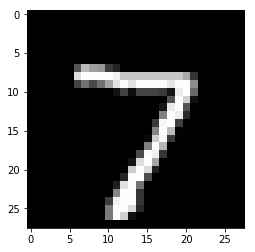

In [29]:
# Visualização do número da imagem
plt.imshow(X_test[0].reshape(28,28), cmap="gray")

In [30]:
# Previsão do número na imagem

# Como é um problema de classificação multiclasse(utilizou-se a função softmax), considera-se que a imagem pertence à classe que
# tem a probabilidade mais alta(pode-se utilizar o argmax, para saber o indice do array com o maior valor).
result = model.predict(image)
result.argmax()

7

## Modelo CNN com 2 camadas de convolução e 2 camadas ocultas

In [21]:
# sequential - uma cada apos a outra
# dense - camadas fully conected, cada neuronio esta conectado a todos os neuronios da camada seguinte

#------------------------------------------------------------------------------------------------------------------------------

# Camada de convolução (conv2D porque é uma imagem):

# Operador de convolução: multiplicação da imagem(matriz de pixeis 28x28) por um detector de caracteristicas, feature detection
# ou filtro ou kernel(matriz normalmente 3x3 para imagens pequenas) que vai originar um mapa de caracteristicas.
# Este mapa tem como objectivo filtrar(detectar) as caracteristicas mais importantes da imagem. 

# Detectores de caracteristicas:32, Utilizam-se 32 matrizes de detectores de caraceristicas que vão originar 32 mapas de
# caracteristicas. Estes detectores de caracteristicas são originados variando os números da matriz até se obter aquele que 
# apresenta o melhor resultado. O recomendado é utilizar 64 kernels e seus multiplos(128, 256, 512, 1024, etc).

# Kernel_size: (3,3) matriz detectora de caracteristicas do tamanho 3x3 

# strider: (1,1) Os valores do mapa de caracteristicas são obtidos com a subdivisão da matriz da imagem a fazer-se movendo um 
# pixel para a direita e um pixel para baixo.

# input_shape: dimensões da imagem e número de canais(1 para imagens sem cor e 3 para imagens com cor)

# função de activação: Aplica a função relu(transforma valores negativos em zero e mantem os restantes iguais) ao mapa de 
# caracteristicas. Isto permite detectar melhor os padrões(Transforma os pontos mais escuros(com valores negativos) em pontos 
# mais claros e mais parecidos com os restantes pontos).

#---------------------------------------------------------------------------------------------------------------------------
# Camada de Normalização
# A normalização dos pixeis já foi feita anteriormente para a camada de entrada(com X_train/255 e X_test/255). Essa 
# normalização tambem pode ser feita para as camadas de convoluções, a normalização é feita no mapa de caracteristicas onde 
# todos os valores passam a estar entre 0 e 1. 
# Isto faz com que o processamento do algoritmo seja mais rapido.

#-------------------------------------------------------------------------------------------------------------------------------

# Camada de Pooling
# O mapa de caracteristicas(neste caso 5x5) é percorrido por uma matriz(neste caso 2x2) para encontrar os valores maiores
#(caracteristicas mais importantes) e formar um nova matriz com esses valores(Poolin matrix).  
# Os valores da matriz de pooling são obtidos com a subdivisão do mapa de caracteristicas a fazer-se movendo uma coluna para a
# direita e uma coluna para baixo.
# Como neste caso tem-se 32 mapas de caracteristicas tem-se igual número de matrizes de pooling.

# Utiliza-se o Max Pooling para se obter o maior valor e assim realçar as caracteristicas principais da imagem. (tambem se podia
# utilizar a média ou o minimo valor).

# pool_size: (2,2) tamanho da matriz utilizada para seleccionar as carateristicas do mapa de caracteristicas. Vai originar uma
# matriz pooling.

#---------------------------------------------------------------------------------------------------------------------------
# Camada de Flattening

# Transformar a matriz de pooling num vector que irá ser utilizado na camada de entrada da rede neural densa.
# Os valores dos neuronios da camada de entrada da rede neural serão os valores desse vector.
#---------------------------------------------------------------------------------------------------------------------------

# 1ª camada oculta
# número de neuronios para primeira modelação:
# (28x28)=784 multiplicada pelo kernel(3x3) origina uma matriz de caracteristicas (26,26) e originar uma matriz de pooling 
# (13x13) e o respectivo array com 169 valores. Ou seja irá-se ter em média 169 valores de entrada.
# ((169+10)/2=90). Optou-se por colocar 128 neuronios.

#---------------------------------------------------------------------------------------------------------------------------
# Camada Dropout
# Ajuda a prevenir o overfitting(que em redes neurais convolucionais tem grande probabilidade de acontecer devido aos muitos
# parametros que se utilizam).
# Coloca-se zeros em alguns valores/neuronios da camada de entrada de forma aleatoria. Escolhe-se a quantidade/percentagem de 
# neuronios que terão valor zero. Ao se colocar o valor zero estes neuronios não teram influencia no modelo. Normalmente 
# utiliza-se uma percentagem entre 20% a 30%. Se for demasiado elevado(maior que 50%) o modelo pode entrar em underfitting, 
# porque não consegue aprender, pois tem demasiadas entradas que não são consideradas.
# Como se utilizam menos variaveis é mais dificil haver alguma que não tenham sido treinada e que o modelo não consiga prever.

#--------------------------------------------------------------------------------------------------------------------------

# Camada de Saida
# Neuronios: Igual ao número de saidas possiveis, neste caso são 10 classes.
# Função de activação: softmax é a função utilizada para problemas de classificação multiclasse. Para se obter a probabilidade
# para cada uma das classes (por ex. para um neurónio tem-se a probabilidade de 10% de ser num 1, 80% num 7 e 10% de ser num 5).
# A classe atribuida será aquela que tem maior probabilidade.

#------------------------------------------------------------------------------------------------------------------------------
# 1ª camada de convolução:
# 1º: Multiplicação da imgem(input) pela detector de caracteristicas para obter o mapa de caracteristicas
# 2º: Percorrer o mapa de caracteristicas com uma matriz para encontrar os valores maiores e formar a matriz de pooling.
# 2ª camada de convolução:
# 3º: Multiplicar a matriz de pooling pelo detector de caracteristicas para obter o mapa de caracteristicas mais refinado
# 4º: Percorrer o mapa de caracteristicas com uma matriz para encontrar os valores maiores e formar a matriz de pooling mais
# refinada

# Camada de entrada da rede neural densa:
# 5º: trasformar a matriz de pooling refinada num vector para servir de camada de entrada da rede neural densa
# 1ª camada de oculta:
# 6º: multiplicar os valores do vector pelos pesos para obter a função soma e aplicar a função relu a esse resultado para obter
# o valor de cada neurónio da 1ª camada oculta
# 2ª camada de oculta:
# 7º: multiplicar os valores dos neuronios da 1ª camada oculta pelos pesos para obter a função soma e aplicar a função 
# relu a esse resultado para obter o valor de cada neurónio da 2ª camada oculta
# camada de saida:
# 8º: multiplicar os valores dos neuronios da 2ª camada oculta pelos pesos para obter a função soma de cada neuronio da camada
# de saida. Aplicar a função softmax aos resultados da função para obter a probabilidade do neuronio pertencer à classe que se
# definiu.

model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), input_shape=(28, 28, 1), activation="relu")) # 1ª camada de convolução e definição da camada
model.add(layers.BatchNormalization())                                          # de entrada
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Conv2D(32, (3,3), activation="relu")) # 2ª camada de convolução
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Flatten()) # funciona como camada de entrada da rede neural oculta

model.add(layers.Dense(units=128, activation="relu")) # 1ª camada de oculta
model.add(layers.Dropout(0.2))

model.add(layers.Dense(units=128, activation="relu")) # 2ª camada de oculta
model.add(layers.Dropout(0.2))

model.add(layers.Dense(units=10, activation="softmax")) # camada de saida


## Compilação e Ajuste do modelo CNN

In [22]:
# Compilação do modelo
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [23]:
# Ajustar os dados de entrada de treino aos dados de saida de treino para treinar o modelo
model.fit(X_train, y_train, batch_size=150, epochs=2, validation_data=(X_test, y_test))

W0703 11:09:29.080182   388 deprecation.py:323] From C:\Users\Bruno\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 196s 3ms/sample - loss: 0.2086 - accuracy: 0.9356 - val_loss: 0.2325 - val_accuracy: 0.9329
Epoch 2/2
60000/60000 [==============================] - 180s 3ms/sample - loss: 0.0622 - accuracy: 0.9813 - val_loss: 0.0420 - val_accuracy: 0.9866


## Validação Cruzada

### Obter os dados

In [2]:
# A base de dados está dividida em dois conjuntos: treino e teste
(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()

In [17]:
# Juntar as variaveis de entrada da base de dados de treino e de teste
X = np.vstack((X_train, X_test))
X.shape

(70000, 28, 28)

In [26]:
# Juntar as variaveis de saida da base de dados de treino e de teste
y = np.hstack((y_train,y_test))
y.shape

(70000,)

### Pré-Processamento dos dados

In [29]:
# Transformar os dados num vector em que o tensorflow consiga fazer a sua leitura.
X = X.reshape(X.shape[0], 28, 28, 1)

In [30]:
# Conversão dos dados do tipo int8 para float32
X = X.astype("float32")

In [31]:
# Normalização dos pixeis
X = X/255

In [ ]:
# Para a cross validation não se pode utilizar o pd.gotDummies() porque ocorre um erro por causa das dimensões do array.
# Neste caso tem de se utilizar um array [70000,1] e não [70000,10] (exigencia da biblioteca sklearn).

# Transformação de variaveis em dummys
#y = utils.to_categorical(y, 10)

### Criar o Modelo

In [32]:
# Utiliza-se o KerasClassifier porque é um problema de classificação

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_validate

In [33]:
### Criar o modelo de CNN numa função

def model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3,3), input_shape=(28, 28, 1), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.Flatten())

    model.add(layers.Dense(units=128, activation="relu"))
    model.add(layers.Dense(units=10, activation="softmax"))
    
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["categorical_accuracy"])
    return model

In [34]:
model = KerasClassifier(build_fn=model, epochs=2, batch_size=150)

### K-Fold Cross Validation

In [36]:
# cross validation

scoring = ['precision_weighted', 'recall_weighted', 'f1_weighted']

scores = cross_validate(estimator=model, X=X, y=y, cv=4, scoring="accuracy", return_train_score=False)

W0703 12:43:41.125284  6472 deprecation.py:323] From C:\Users\Bruno\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 52500 samples
Epoch 1/2
52500/52500 [==============================] - 27s 513us/sample - loss: 0.2496 - categorical_accuracy: 0.9279
Epoch 2/2
52500/52500 [==============================] - 26s 498us/sample - loss: 0.0770 - categorical_accuracy: 0.9781
Train on 52500 samples
Epoch 1/2
52500/52500 [==============================] - 27s 510us/sample - loss: 0.2388 - categorical_accuracy: 0.9330
Epoch 2/2
52500/52500 [==============================] - 26s 504us/sample - loss: 0.0747 - categorical_accuracy: 0.9781
Train on 52500 samples
Epoch 1/2
52500/52500 [==============================] - 26s 487us/sample - loss: 0.2517 - categorical_accuracy: 0.9293
Epoch 2/2
52500/52500 [==============================] - 25s 469us/sample - loss: 0.0719 - categorical_accuracy: 0.9783
Train on 52500 samples
Epoch 1/2
52500/52500 [==============================] - 26s 493us/sample - loss: 0.2627 - categorical_accuracy: 0.9241
Epoch 2/2
52500/52500 [==============================] - 26s 493us/s

In [37]:
# Valores obtidos para a accuracy atraves de cross validation
scores

{'fit_time': array([56.34674001, 54.07681227, 51.43444228, 52.45727754]),
 'score_time': array([3.34220004, 2.94535613, 2.36308646, 2.61775637]),
 'test_score': array([0.97714286, 0.97931429, 0.97582857, 0.98211429])}

In [38]:
# accuracy média dos sub conjuntos de teste
np.mean(scores["test_score"])

0.9786

In [39]:
# desvio padrão obtido atraves dos valores da accuracy dos sub conjuntos de teste
# quanto maior este valor maior é a probabilidade de existir overfitting (o modelo não generaliza bem e adapta-se demasiado bem
# aos dados de treino, e quando se utilizam dados novos o modelo não se adapta bem)

np.std(scores["test_score"])

0.002380361831524715

## Augumentation - Alteração das caracteristicas das imagens

In [64]:
# Altera as imagens. As novas imagens são geradas a partir das existentes aplicando rotações, aumento do zoom, alteração da 
# direcção dos pixeis, etc.

# Augmentation não se refere ao processo de aumentar o número total de imagens. É o processo de criar diferentes variantes das
# imagens originais(aplicando rotações, zoom, etc.). As imagens geradas não são totalmente diferentes das originais mas uma
# transformação aleatoria delas.

### Transformações nas imagens

In [65]:
# rotation_range: grau de rotação das imagens originais
# horizontal_flip: rotações horizontais
# shear_range: mudar a direcção dos pixeis
# height_shift_range: modificar a faixa de altura da imagem
# zoom_range: alterar o zoom da imagem

train_data_base_generator = preprocessing.image.ImageDataGenerator(rotation_range=7, horizontal_flip=True, shear_range=0.2,
                                                         height_shift_range=0.07, zoom_range=0.2)

In [66]:
# Como não se utilizaram parâmetros não faz alterações na imagem. Mantem as imagens originais.
test_data_base_generator = preprocessing.image.ImageDataGenerator()

### Criar nova base de dados

In [75]:
# Criar um base de dados de treino a partir das imagens originais(X_train, y_train)

# batch_size: 150, calcula-se o erro de um conjunto de 150 dados e actualizam-se todos os pesos e escolhe-se um detector de 
# caracteristicas melhor. De seguida calcula-se o erro para o seguinte conjunto de 150 dados e actualizam-se todos os pesos e 
# escolhe-se um detector de caracteristicas melhor. E assim sucessivamente.

train_data_base = train_data_base_generator.flow(X_train, y_train, batch_size=150)

In [76]:
# Criar um base de dados de teste a partir das imagens originais(X_test, y_test)
test_data_base = test_data_base_generator.flow(X_test, y_test, batch_size=150)

### Modelo de CNN

In [77]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), input_shape=(28, 28, 1), activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Flatten())

model.add(layers.Dense(units=128, activation="relu"))
model.add(layers.Dense(units=10, activation="softmax"))

In [78]:
# Compilação do modelo
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [79]:
# Em vez do model.fit() utiliza-se o model.fit_generator()

#-------------------------------------------------------------------------------------------------------------------------------

# epochs: Quantas vezes o algoritmo percorre o conjunto de dados de treino totalmente e escolhe-se um detector de 
# carateristicas melhor. 

# 1ª epoca- calcula o erro para os primeiros 150 dados e actualiza todos os pesos e escolhe-se um detector de caracteristicas 
# melhor. Calcula o o erro para os 150 dados seguintes e actualiza todos os pesos e escolhe-se um detector de caracteristicas 
# melhor. E assim sucessivamente.
# 2ª epoca- calcula o erro para os primeiros 150 dados(com os pesos da 1ª epoca) e actualiza todos os pesos e escolhe-se um
# detector de caracteristicas melhor(melhor do que o obtido na 1ª epoca).
# Calcula o o erro para os 150 dados seguintes(com os pesos da 1ª epoca) e actualiza todos os pesos e detector de 
# caracteristicas. E assim sucessivamente.
# 6000/150 = 40 batchs. Os pesos e o detector de caracteristicas são actualizados 40 vezes em cada epoca.

#-------------------------------------------------------------------------------------------------------------------------------

# steps_per_epoch: 60000/150 = 400 
# Número de iterações por epoca. Garante que apenas as primerias 400 amostras(batchs) são consideradas. É util quando se tem um
# conjunto de dados demasiado grande para ser processado.
# 1ª epoca: calcula o erro para os primeiros 150 dados e actualiza todos os pesos e escolhe-se um detector de caracteristicas 
# melhor. Calcula o o erro para os 150 dados seguintes e actualiza todos os pesos e escolhe-se um detector de caracteristicas 
# melhor. E assim sucessivamente até terem sido realizadas 400 iterações. Ou seja apenas se consideraram as primeiras 60000
# imagens.
# Assim as 60000 imagens originais são transformadas por epoca. 

# Com o steps_per_epoch=n_samples/batch_size em cada epoca cada amostra é transformada apenas uma vez e portanto neste caso
# vão ser geradas 60000 imagens transformadas a cada epoca. Essas imagens vão ser as usadas para se fazer o treino. Na proxima
# epoca uma nova transformação aleatoria das 60000 imagens é feita e o treino é feito com essas imagens tranformadas.
# Ou seja não se está a aumentar o número de imagens de treino de 60000 para um número maior, mas a fazer o treino em 60000
# imagens que são transformadas de epoca para epoca.

# Por exemplo na primeira epoca a 1ª imagem orinal é transformada aleatoriamente e faz-se o treino com base nessa transformação.
# Na segunda epoca a 1ª imagem orinal volta a ser transformada aleatoriamentee e faz-se o treino com base nessa transformação.
# E assim sucessivamente.
# Para 5 epocas cada imagem é transformada 5 vezes.

# Não faz sentido alterar o steps_per_epoch=n_samples/batch_size para um valor diferente.
# Por exemplo ao se escolher o steps_per_epoch=2x(n_samples/batch_size) para aumentar o número de transformações que uma imagem
# sofre por epoca(de 1 transformação para 2). Esta-se a fazer com que cada epoca seja 2 epocas normais. Ou seja, deveria-se
# aumentar o númemro de epocas e não o steps_per_epoch.

#-------------------------------------------------------------------------------------------------------------------------------

#validation_steps: Semelhante ao steps_per_epoch mas aplicado ao conjunto de dados de teste.

#-------------------------------------------------------------------------------------------------------------------------------

# Validation data: Avaliação do modelo utilizando a base de dados de teste (val_accuracy).

# Ajustar os dados de entrada de treino aos dados de saida para treinar o modelo(Estão os dois na base de dados de treino).
model.fit_generator(train_data_base, steps_per_epoch=60000/150, epochs=4, validation_data=test_data_base, 
                    validation_steps=10000/150)

Epoch 1/4
400/400 [==============================] - 41s 103ms/step - loss: 0.5785 - accuracy: 0.8163 - val_loss: 0.1968 - val_accuracy: 0.9368
Epoch 2/4
400/400 [==============================] - 39s 96ms/step - loss: 0.2429 - accuracy: 0.9236 - val_loss: 0.1125 - val_accuracy: 0.9651
Epoch 3/4
400/400 [==============================] - 41s 104ms/step - loss: 0.1809 - accuracy: 0.9450 - val_loss: 0.0995 - val_accuracy: 0.9679
Epoch 4/4
400/400 [==============================] - 41s 102ms/step - loss: 0.1444 - accuracy: 0.9553 - val_loss: 0.0792 - val_accuracy: 0.9758
